In [1]:
"""
刘某历经千辛万苦，终于整利索的代码，附有详细中文注释
"""

'\n刘某历经千辛万苦，终于整利索的代码，附有详细中文注释\n'

In [2]:
# 调库
import pickle # 用来序列化的包
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer # 该类允许使用两种方法向量化一个文本语料库： 将每个文本转化为一个整数序列（每个整数都是词典中标记的索引）； 或者将其转化为一个向量，其中每个标记的系数可以是二进制值、词频、TF-IDF权重等。
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import Embedding, Dense, TimeDistributed, Concatenate, BatchNormalization
from keras.layers import Bidirectional, Activation, Dropout, GRU, Conv1D

from sklearn.model_selection import train_test_split, KFold
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras.regularizers import l1, l2
import tensorflow as tf

import os

In [3]:
# 读数据,这两个数据都是做过onehot编码的
# cb6133         = np.load("../data/cb6133.npy")
cb6133filtered = np.load("../data/cullpdb+profile_6133_filtered.npy.gz")
cb513          = np.load("../data/cb513+profile_split1.npy.gz")

# 看一眼数据大小
# print(cb6133.shape)
print(cb6133filtered.shape) #(5534, 39900),39900=57*700
print(cb513.shape)
# cb6133filtered[0,-57:-1]

(5534, 39900)
(514, 39900)


In [4]:
# 部分超参数设置
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
maxlen_seq = r = 700 # protein residues padded to 700，统一设置成700的序列长度
f = 57  # number of features for each residue，onehot后的总特征数量=22+8+5+22
residue_list = list('ACEDGFIHKMLNQPSRTWVYX') + ['NoSeq'] # 长度是21+1
q8_list      = list('LBEGIHST') + ['NoSeq']
columns = ["id", "len", "input", "profiles", "expected"]

In [5]:
# 函数定义
def get_data(arr, bounds=None): # 把预测得到的分段的 onehot编码 解码成我们想要的氨基酸序列
    
    if bounds is None: bounds = range(len(arr)) # 应该是蛋白质序列的条数
    
    data = [None for i in bounds] # 新建了一个长度和arr一样的空列表
    for i in bounds:
        seq, q8, profiles = '', '', []
        for j in range(r):
            jf = j*f # 1*57---->700*57
            
            # Residue convert from one-hot to decoded，应该是从onehot编码解码为氨基酸序列
            residue_onehot = arr[i,jf+0:jf+22] # 取了某一条氨基酸序列中的某个氨基酸的57各特征中的前22个特征的概率？
            residue = residue_list[np.argmax(residue_onehot)] # 这22个特征中概率最大的成为这个氨基酸的特征，此处为氨基酸的种类

            # Q8 one-hot encoded to decoded structure symbol，应该是从onehot解码为氨基酸二级结构
            residue_q8_onehot = arr[i,jf+22:jf+31] # 同上
            residue_q8 = q8_list[np.argmax(residue_q8_onehot)] # 同上

            if residue == 'NoSeq': break      # terminating sequence symbol，遇到编码为NoSeq，应该是意味着这串氨基酸序列结束了

            # 下面这仨应该就是蛋白质的一些其他特征，包括profile（亲戚关系？）啥的，可能还有什么像是溶剂可溶性？
            nc_terminals = arr[i,jf+31:jf+33] # nc_terminals = [0. 0.]
            sa = arr[i,jf+33:jf+35]           # sa = [0. 0.]
            profile = arr[i,jf+35:jf+57]      # profile features，这个就是PSSM亲戚特征
            
            
            
            seq += residue # concat residues into amino acid sequence，把氨基酸序列预测结果连接起来
            q8  += residue_q8 # concat secondary structure into secondary structure sequence， 把氨基酸二级结构预测结果连接起来
            profiles.append(profile) # 将亲戚信息保存起来，后续用来作为网络的输入的一部分
        
        data[i] = [str(i+1), len(seq), seq, np.array(profiles), q8] # 【蛋白质编号，蛋白质长度，蛋白质序列，蛋白质亲戚信息，蛋白质二级结构】
    
    return pd.DataFrame(data, columns=columns) # 输出成pandas的数据结构，二维的貌似？

# The custom accuracy metric used for this task，要自己定义一个正确率，不然keras默认的那个accuracy是包含那些700的长度后面补的NoSeq
def myaccuracy(y_true, y_pred):
    y = tf.argmax(y_true, axis =- 1) # 用最后一个维度进行封包，然后不同包之间进行比较，比较对应位置的大小
    y_ = tf.argmax(y_pred, axis =- 1)
    mask = tf.greater(y, 0) # y中比0大的赋值为true，比0小和等于0的赋值为false，这样子就把后面那些空的去掉了，只比对有值的内容的正确率
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx()) # floatx是默认的浮点数类型，tf.boolean_mask返回mask为true的y的对应位置的内容，equal返回布尔型的list，cast类型转换此处为1.和0

# Maps the sequence to a one-hot encoding
# 简单onehot解码
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i] # 字符串加法
        else:
            break
    return s

# 简单onehot编码
def seq2onehot(seq, n):
    out = np.zeros((len(seq), maxlen_seq, n)) # （氨基酸序列条数，700，22（onehot的维度））
    for i in range(len(seq)): # i是第几条氨基酸序列的序号
        for j in range(maxlen_seq): # j是第i条氨基酸序列的第几个氨基酸的序号，1---700
            out[i, j, seq[i, j]] = 1 # 懂了，seq[i,j]这个值是多少（x），我们就在第几(x)个位置填1，这个值只能有22种可能性
    return out

# ngrams第N个词的出现只与前面N-1个词相关，而与其它任何词都不相关，整句的概率就是各个词出现概率的乘积。这些概率可以通过直接从语料中统计N个词同时出现的次数得到。常用的是二元的Bi-Gram和三元的Tri-Gram
def seq2ngrams(seqs, n = 1): # 此处n=1，所以某一条氨基酸序列中每个氨基酸前后不相关，所以此时实际效果就像把序列每个氨基酸分开了
    return np.array([[seq[i : i + n] for i in range(len(seq))] for seq in seqs])

def decode_results(y_, reverse_decoder_index): # 根据字典进行onehot解码
    print("prediction: " + str(onehot_to_seq(y_, reverse_decoder_index).upper())) # .upper()小写字母转为大写字母
    return str(onehot_to_seq(y_, reverse_decoder_index).upper())

def run_test(_model, data1, data2, data3, csv_name, npy_name):
    reverse_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()} # 把字典反向，用来解码，现在是1:'h'这样子
    reverse_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()} # 把字典反向用来编码
    
    # Get predictions using our model
    y_test_pred = _model.predict([data1, data2, data3]) # 【我们自己onehot的氨基酸种类序列，embedding张成的64维的氨基酸种类序列，PSSM信息】

    decoded_y_pred = []
    for i in range(len(test_input_data)):
        res = decode_results(y_test_pred[i], reverse_decoder_index) # 应该是从onehot解码成二级结构序列
        decoded_y_pred.append(res)

    # Set Columns，设置输出的dataframe有哪些内容
    out_df = pd.DataFrame()
    out_df["id"] = test_df.id.values
    out_df["real"] = test_df.expected.values
    out_df["predict"] = decoded_y_pred

    # 输出一下测试集的预测正确率
    testaccseq=myaccuracy(test_target_data,y_test_pred)
    testacc=np.sum(testaccseq)/testaccseq.shape
    print('测试集的正确率：',testacc)
    # Save results，这里保存的是解码后的
    with open(csv_name, "w") as f:
        out_df.to_csv(f, index=False)

    np.save(npy_name, y_test_pred) # 这里保存的是没解码的

def conv_block(x, activation=True, batch_norm=True, drop_out=True, res=True): # 自己定义一个卷积层
    cnn = Conv1D(64, 11, padding="same")(x) # 将（5534,700,22+64+22）卷积到（5534,700,64），这里不用各自卷积是因为本来就是随机的卷积核
    if activation: cnn = TimeDistributed(Activation("relu"))(cnn) # 这个封装器将一个层应用于输入的每个时间片（一个batch中的每个样本,这里是700个单独做）。输入至少为 3D，且第一个维度应该是时间所表示的维度。懂了，因为每条氨基酸序列之间并没有什么关系，所以各自操作
    if batch_norm: cnn = TimeDistributed(BatchNormalization())(cnn) # 批量标准化层，在每一个批次的数据中标准化前一层的激活项， 即，应用一个维持激活项平均值接近 0，标准差接近 1 的转换。
    if drop_out:   cnn = TimeDistributed(Dropout(0.5))(cnn)
    if res:        cnn = Concatenate(axis=-1)([x, cnn]) # 把最后一维串联起来，concatenate操作是网络结构设计中很重要的一种操作，经常用于将特征联合，多个卷积特征提取框架提取的特征融合或者是将输出层的信息进行融合
    
    return cnn

def super_conv_block(x): # 使用不同维度的卷积核进行一维卷积然后concatenate到一起，即使用不同维度的特征
    c3 = Conv1D(32, 1, padding="same")(x) # 核大小32，步长1
    c3 = TimeDistributed(Activation("relu"))(c3)
    c3 = TimeDistributed(BatchNormalization())(c3)
    
    c7 = Conv1D(64, 3, padding="same")(x)
    c7 = TimeDistributed(Activation("relu"))(c7)
    c7 = TimeDistributed(BatchNormalization())(c7)
    
    c11 = Conv1D(128, 5, padding="same")(x)
    c11 = TimeDistributed(Activation("relu"))(c11)
    c11 = TimeDistributed(BatchNormalization())(c11)
    
    x = Concatenate(axis=-1)([x, c3, c7, c11]) # 不同维度的特征联合
    x = TimeDistributed(Dropout(0.5))(x)
    return x

def CNN_BIGRU():
    # Inp is one-hot encoded version of inp_alt，就是这句英文的意思，需要在调用的时候被输入
    inp          = Input(shape=(maxlen_seq, n_words))
    inp_alt      = Input(shape=(maxlen_seq,))
    inp_profiles = Input(shape=(maxlen_seq, 22))

    # Concatenate embedded and unembedded input
    x_emb = Embedding(input_dim=n_words, output_dim=64, 
                      input_length=maxlen_seq)(inp_alt) # 将正整数（索引值）转换为固定尺寸的稠密向量。该层只能用作模型中的第一层。此处都变成64维的。目的是为了让网络的初始化更加合理，而不是像onehot那样子很稀疏，这样子网络能够更好地收敛。而且输入支持维度不同的list。
    # 网络结构1
    x = Concatenate(axis=-1)([inp, x_emb, inp_profiles]) # 这个地方将：【我们自己onehot的氨基酸种类序列，embedding张成的64维的氨基酸种类序列，PSSM信息】这仨连接在一起，都输入网络进行学习

    # 网络结构2：CNN部分，具体几乘几还不确定
    x = super_conv_block(x)
    x = conv_block(x)
    x = super_conv_block(x)
    x = conv_block(x)
    x = super_conv_block(x)
    x = conv_block(x)

    # 网络结构3：bidir-GRU部分
    x = Bidirectional(GRU(units = 256, return_sequences = True, recurrent_regularizer=l2(0.2)))(x) 
    # RNN 的双向封装器，对序列进行前向和后向计算。
    # units: 正整数，输出空间的维度。
    # return_sequences: 布尔值。是返回输出序列中的最后一个输出，还是全部序列。
    # recurrent_regularizer: 运用到 recurrent_kernel 权值矩阵的正则化函数 (详见 regularizer)。lambda=0.2
    x = TimeDistributed(Dropout(0.5))(x) # 0.5的被丢弃了
    x = TimeDistributed(Dense(256, activation = "relu"))(x) # Dense：就是你常用的的全连接层。
    x = TimeDistributed(Dropout(0.5))(x)
    
    y = TimeDistributed(Dense(n_tags, activation = "softmax"))(x)
    
    model = Model([inp, inp_alt, inp_profiles], y) # 继承keras的Model类，设置输入为三个元素的list，输出为y
    
    return model # 定义网络

def train(X_train, y_train, X_val=None, y_val=None):
    """
    Main Training function with the following properties:
        Optimizer - Nadam
        Loss function - Categorical Crossentropy
        Batch Size - 128 (any more will exceed Collab GPU RAM)
        Epochs - 50
    """
    model = CNN_BIGRU() # 实例化自己定义的网络
    model.compile(
        optimizer="Nadam", # 某种优化算法
        loss = "categorical_crossentropy", # 交叉熵损失函数
        metrics = ["accuracy", myaccuracy]) # 衡量指标：700个的正确率（其中包括后面补的0），我自己写的正确率（序列多长算多长）
    
    
    #########################
    print(model.summary())
    
    
    if X_val is not None and y_val is not None:
        history = model.fit( X_train, y_train,
            batch_size = 128, epochs = 100,
            validation_data = (X_val, y_val)) # 用来评估损失，以及在每轮结束时的任何模型度量指标。模型将不会在这个数据上进行训练。
    else:
        history = model.fit( X_train, y_train,
            batch_size = 64, epochs = 100, verbose=1) # 一个 History 对象。其 History.history 属性是连续 epoch 训练损失和评估值，以及验证集损失和评估值的记录（如果适用）。

    return history, model



In [6]:
# 数据处理
'''
此处稍微记录一下,免得再看到处翻

通用：
tokenizer_encoder：氨基酸种类词典
tokenizer_decoder：氨基酸二级结构词典
n_words：氨基酸种类词典词种类数，22
n_tags：氨基酸二级结构词典词种类数，9

训练：
train_df：训练数据的dataframe，其中包括【序号，序列长度，氨基酸种类序列，PSSM信息，二级结构种类序列】
train_input_seqs：氨基酸种类序列
train_target_seqs：二级结构种类序列
train_input_grams：氨基酸种类序列切分开
tokenizer_encoder.texts_to_sequences(train_input_grams)：氨基酸种类序列切分开后转成数字序列，其中数字种类总共有22种
train_input_data_alt：氨基酸种类序列，切分开，后转成数字序列，后第二个维度扩展到700，也就是都认为长度是700
train_input_data：氨基酸种类序列，切分开，后转成数字序列，后第二个维度扩展到700，onehot
tokenizer_decoder.texts_to_sequences(train_target_seqs)：二级结构种类序列转成数字序列，数字种类共9种
sequence.pad_sequences(train_target_data,maxlen = maxlen_seq, padding='post')：二级结构种类序列转成数字序列后第二个维度扩展到700
train_target_seqs：二级结构种类序列转成数字序列后第二个维度扩展到700后进行onehot并且再复制一份反的用来做交叉熵
train_profiles：未处理的onehot的PSSM信息
train_profiles_np：补长到700的onehot的PSSM信息

测试：
test_df：同
test_input_seqs：
test_input_grams：
tokenizer_encoder.texts_to_sequences(test_input_grams)：种类
test_input_data_alt：数字序列
test_input_data：
tokenizer_decoder.texts_to_sequences(test_df.expected.values)：二级结构
sequence.pad_sequences(test_target_data, maxlen = maxlen_seq, padding='post')：数字序列
test_target_data：将测试集的氨基酸二级结构序列进行onehot
test_profiles
test_profiles_np

'''


# Train-test Specification，得到了漂亮的数据结构
train_df = get_data(cb6133filtered) # 用来训练
test_df  = get_data(cb513) # 用来测试

# Computes and returns the n-grams of a particular sequence, defaults to trigrams
# Loading and converting the inputs to trigrams，加载并且将其转置，此处转置没啥用，但是如果上面n大于1，就有用了
train_input_seqs, train_target_seqs = \
    train_df[['input', 'expected']][(train_df.len.astype(int) <= maxlen_seq)].values.T # astpye(int)将int64转为int32，.values提取值（不包含序号），.T表示转置
train_input_grams = seq2ngrams(train_input_seqs)

# Same for test，同上
test_input_seqs = test_df['input'].values.T
test_input_grams = seq2ngrams(test_input_seqs)

# Initializing and defining the tokenizer encoders and decoders based on the train set
# Tokenizer是一个用于向量化文本，或将文本转换为序列（即单词在字典中的下标构成的列表，从1算起）的类。Tokenizer实际上只是生成了一个字典，并且统计了词频等信息，并没有把文本转成需要的向量表示。
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(train_input_grams) # 生成氨基酸种类词典
tokenizer_decoder = Tokenizer(char_level = True) # char_level：如果为True，每个字符将被视为一个标记
tokenizer_decoder.fit_on_texts(train_target_seqs) # 生成氨基酸二级结构词典

# Computing the number of words and number of tags for the keras model，统计一下两个字典的数量，keras运行时需要这个参数
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1

# Using the tokenizer to encode and decode the sequences for use in training，用字典来将字符转换为数字
# Inputs
train_input_data = tokenizer_encoder.texts_to_sequences(train_input_grams) # 将氨基酸序列通过字典,变成数字序列
train_input_data = sequence.pad_sequences(train_input_data,
                                          maxlen = maxlen_seq, padding='post') # 把不等长的list变成等长,默认填充是０,padding='post'是后填充即后面是0

# Targets
train_target_data = tokenizer_decoder.texts_to_sequences(train_target_seqs) # 将氨基酸二级结构序列通过字典，变成数字序列
train_target_data = sequence.pad_sequences(train_target_data,
                                           maxlen = maxlen_seq, padding='post') # 同上
train_target_data = to_categorical(train_target_data) # to_categorical就是将类别向量转换为二进制（只有0和1）的矩阵类型表示，此处用途为简易onehot

# Use the same tokenizer defined on train for tokenization of test，对测试集进行同上操作
test_input_data = tokenizer_encoder.texts_to_sequences(test_input_grams)
test_input_data = sequence.pad_sequences(test_input_data,
                                         maxlen = maxlen_seq, padding='post')
test_target_data = tokenizer_decoder.texts_to_sequences(test_df.expected.values) # 将测试集的氨基酸二级结构序列通过字典，变成数字序列
test_target_data = sequence.pad_sequences(test_target_data,
                                           maxlen = maxlen_seq, padding='post') # 同上
test_target_data = seq2onehot(test_target_data,n_tags) # 将测试集的氨基酸二级结构序列进行onehot


train_input_data_alt = train_input_data # 做了个备份
train_input_data = seq2onehot(train_input_data, n_words) # 对训练集的data进行onehot
train_profiles = train_df.profiles.values # 取出PSSM信息

test_input_data_alt = test_input_data # 同上
test_input_data = seq2onehot(test_input_data, n_words)
test_profiles = test_df.profiles.values

# 下面这一段的作用是把5534条不同长度的氨基酸序列中每个氨基酸的PSSM信息，存成一样700长的氨基酸序列中每个氨基酸的PSSM信息，存成三维的np数组，补充出来的那些氨基酸的PSSM信息都是0
train_profiles_np = np.zeros((len(train_profiles), maxlen_seq, 22))
for i, profile in enumerate(train_profiles):
    for j in range(profile.shape[0]):
        for k in range(profile.shape[1]):
            train_profiles_np[i, j, k] = profile[j, k]

# 同上
test_profiles_np = np.zeros((len(test_profiles), maxlen_seq, 22))
for i, profile in enumerate(test_profiles):
    for j in range(profile.shape[0]):
        for k in range(profile.shape[1]):
            test_profiles_np[i, j, k] = profile[j, k]


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 700)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 700, 22)]    0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 700, 64)      1408        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 700, 22)]    0                                            
_______________________________________________________________________________________

Epoch 1/100
87/87 [==============================] - 38s 435ms/step - loss: 29.9646 - accuracy: 0.8286 - myaccuracy: 0.4660
Epoch 2/100
87/87 [==============================] - 37s 422ms/step - loss: 1.0792 - accuracy: 0.8821 - myaccuracy: 0.6147
Epoch 3/100
87/87 [==============================] - 37s 425ms/step - loss: 0.3322 - accuracy: 0.8912 - myaccuracy: 0.6440
Epoch 4/100
87/87 [==============================] - 37s 425ms/step - loss: 0.2970 - accuracy: 0.8960 - myaccuracy: 0.6596
Epoch 5/100
87/87 [==============================] - 37s 424ms/step - loss: 0.2902 - accuracy: 0.8980 - myaccuracy: 0.6662
Epoch 6/100
87/87 [==============================] - 37s 425ms/step - loss: 0.2836 - accuracy: 0.8999 - myaccuracy: 0.6723
Epoch 7/100
87/87 [==============================] - 37s 425ms/step - loss: 0.2789 - accuracy: 0.9010 - myaccuracy: 0.6760
Epoch 8/100
87/87 [==============================] - 37s 425ms/step - loss: 0.2756 - accuracy: 0.9021 - myaccuracy: 0.6794
Epoch 9/100
87/

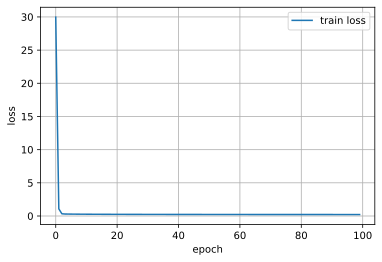

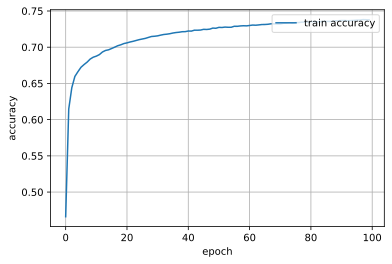

In [7]:
# 模型训练以及保存信息
# 打包一下训练用的数据（data和label）
X_train = [train_input_data, train_input_data_alt, train_profiles_np]
y_train = train_target_data

history, model = train(X_train, y_train) # 模型训练，并且输出训练历史，有可以设置的参数

# 画图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# 画loss图
plt.plot(history.history['loss'],label='train loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.savefig('train_loss.png', dpi=500, bbox_inches='tight')
plt.show()
# 画正确率图
plt.plot(history.history['myaccuracy'],label='train accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc="upper right")
plt.savefig('train_accuracy.png', dpi=500, bbox_inches='tight')
plt.show()

# Save the model as a JSON format，把模型结构和参数权重保存下来
model.save_weights("cb513_weights_1.h5")
with open("model_1.json", "w") as json_file:
    json_file.write(model.to_json())

# Save training history for parsing，把训练过程保存下来
with open("history_1.pkl", "wb") as hist_file:
    pickle.dump(history.history, hist_file)
    
# model.load_weights("cb513_weights_1.h5")
# with open("history_1.pkl",'rb') as f:
#     data = pickle.load(f)

In [8]:
# 测试预测效果
# Predict on test dataset and save the output
run_test(model,
    test_input_data[:],
    test_input_data_alt[:],
    test_profiles_np[:],
    "cb513_test_1.csv", "cb513_test_prob_1.npy") # 保存的是解码后的和没解码的

prediction: LLLHHHHHHHHHHHHHHHHHHHHLLTTLLLSSLEEEELTTSLEEEEEELLSLEEEEEEEEEEEEELL
prediction: LLEEEEELTTSTLLHHHHHHHHHHHHTTLLEEEEELLGGTTLLLHHHHHHHHHHHTLLLLLLLLLLEEELTTSLEELLHHHHHHHHL
prediction: LLLLLLLLLGGGTTLLLLTTHLHHLLHHHHHHHHHLLLSSLLSEEEEEELLSSLHHHHHHHHHHHTTTTTLLLLGGGSLLTTLSLEEEELTTTLLLLLLLLHHHHHHHHHHTLLGGTTLEEELTTSLBLSSHHHHHHHTTLEEEEEEEEELLLLHHHHHHHTLSSGGGLLTHHHHTTSLTHHHHTTLLSLHHHHHHHTLLSEEEELLGGGHLLLLLTTLTTTLLHHHHHHHTTLEEESSHHHHTTLLLLLTTSLEEEEELTTLLLEEEELLLLLLTTLLLSLLLLLLLLTTLLTTSLLHHHHHHHHHHHHHTLTTSEEEEEELGLLLTTLTTTLHHHHHHHHHHHHHHHHHHHHHHHHHTLEEEEEEELTTTLLLLLLLLSSSTTHHHHHHLTTSLEEEEEELLLTTLLLLLLLLLEEEEEELTTGGGLLSLLLLHHHHHHHHHHHTLL
prediction: LLLEEELTTTTLLTTLEEEEEEETTTLEEEEEEEEEETTLLLLLGGGEEEEEELTTSLEEEEEEEEEEEEEELTTSLEEEEEELLSSLEEEEEELLSLLLLLEEELLL
prediction: LLGGGSLEEEEEELTTTLSLHHHHHHHHHHTTLLLLLSSHHHHHHHHLLSSLSSHHHHHHHHHHHHHHHTTLHHHHHHHHHHHHHHHHHTTLEEEEEEELHHHHTTLLLLLLLLLLLTTLLLHHHHHHHHHHHHHHHHHHHLLEEEEEEEEETTLLHHHHHHHHHHGGGTTTEEEEEELLLLTTTTLGGGSHHHHHHHHHHHHTTLEEEEELLLLSLHHHHHHHH

prediction: LLLLLLLLTTSLLLLLLTTLLLEETTTSLELSLHHHHHHHHHHHTSLEEEEEELLL
prediction: LLTTLHHHHHHHHHHHHHHHHHHHHHHHHLTTTLLGGGTTLLLLLHHHHHHHHHHHHHHHHHHHHHHTTLLLLLLLLTTSLLLLLLLLLLLELTTSLLLLLLLTTLEEELLTTLLHHHHHHHHHHHHHHHHTTSEELTTSLEEEGGLLLLHHHHHHHHHLLTTLLLHHHHHHHHHHHHHHHHHHLLTTSLTLLLLLGGGLTTTLTSLHHHHHHHHHHHHHHHHHHHHL
prediction: LEEEEEEELLLTTSLEEEELSEEEELTTLEEEEEELSSSLEEEEETTLLLTTLGGGLLLTTLEEEEEESSLEEEEEEEELLGGGTLEEEEEELSLLSLHHHHHHLLLLHHHHHHHHHHHL
prediction: LLLHHHHHSLTTLLLHHHHHHHHHHHHHLLTLLLLLLLLLHHHHHHHHHHHHHLLGGLLGGGSLHHHHHHHHHHHHHHSSSLLSLGGGHHHHHHHGGGLLSHHHHHHHHHHHHHLTTSLHHHHHHHHHHHHHHHHHHHHHTTLLLLHHHHHHHHHHHHHHLLTTLTTLHHHHHHHHHHHHHHHHLTLLLLLLLLL
prediction: LLLLLLEEEEEESSLSSGGGSLTTLEEELLSHHHHHHHHHHLTTEEEEELLSLHHHHHHHHHTTSLSEEEEEHHHHHHTTLGGGLSEELLGGGLLLLLLLLL
prediction: LEEEEEELTTLLTTLLLLLHHHHHHHHTTSLLSTLLHHHHHHLTTLLLLSSLEEEEEELSSSHHHHHHHHHHHHHLHHHHHHTLTTLLLLLLLLTLLTTLHHHHHHHHTSTTEEEEEEHHHHHHTTLLEEEEELTTSLBLLLLHHHHHHHHTTLLLLTTLEEEEELLLSTTLLLLL
prediction: LLLLLLLLLLLLLLLTLSLEEETTEELSSEEEE

prediction: LLLLHHLLLLHHHHHHHHHHHHHHHTLHHHHHHHHHHHHHHHLGGGGGGGGGGTLGGGGTTLHHHHHHHHHHHHHHHHHHHHTTLHHHHHHHHHHHHHHHHHTTLLHHHHHHHHHHHHHHHHHTTLLHHHHHHHHHHHHHHHHHL
prediction: LLLTTTLTTLTEEEEELTTSLEEEELLLLTTSLLLLLTLLLTTLEEELLLL
prediction: LLHHHHHHHTTHHGGLSLHHHHHHHHHTTLEEEEEEELTTSSLLLHHHHHHHHHHHHHHHTTLLLEEEELLTTTTTLLTTSLGGLLLLLLHHHHHHHHHHHHHHHGGGSLLLSSSSLLEEEELGGGTTTLLHHHHHHHHLTTLLHHHHHHHHHHHHHHHHTLLHHHHHHHHHHHHHHHHHHHHHTLEEEELLSLHHHHHHTTEEEEEETTTEEEEEEEEEEELTTSLEEEELTTSEEEELTTLLLHHHHHHHHHTSLHHHHHHHHHHHHTSLHHHHHHHHHHHHHLHHHHHHHHHHHHHHHHHHHLHHHHHHHHHHL
prediction: LLLLGGGGEEEEEEEELLLSLLTTSLLLLTTLLHHHHHHHHHHTTLSEEEELGGGLLLTTLLHHHHHHHHHHHHHHHHHTTLLEEEEELLLLLLGGGTTTTLLLLLHHHHHHHHHHHHHHHHHHHHTTLSEEEEELLLLLLLSTTLSLHHHHHHHHHHHHHHHHHHHHHTTLLLEEEEELLTTSLLTLLLLSSHHHHHHHHHHTTLGGGEEEEELLLGGGGTTLLHHHHHHHHHHTTLEEEEELLSLTTLLELTTLLLLLSLHHHHHHHHHHHHTTLLTSLLLLLLLEEELLLLLLLSHHHHHHHHHHHHHHHHHHHHHHHHHHHHLHHHHHHHHHTTHHHHHHHHHHTTLLHHHHHHTHHHHTTLLHHHHHTTLLHHHHHHHHHHHHHHTLL
prediction: LLHHHHHHHHHHHHHTHLLLLTTLLLLLLL